In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import math
import numpy as np
import itertools
from scipy.stats import bootstrap
from scipy.stats import beta as beta_dist
from joblib import Parallel, delayed
from scipy.special import beta as B
from scipy.stats import bernoulli

### Case 1: IID

Given the observed data $x_1, \dots, x_t$, we consider the following estimates.

MLE:

$$\hat p_s = \frac{1}{t} \sum_{r = 1}^t x_i, \ \forall s > t$$

In [444]:
def hypothesis(p, size):
    h = np.random.uniform(low=0, high=1, size=size)
    h[p > 0.5, :] = 1
    h[p < 0.5, :] = 0
    return h

def loss(truth, pred):
    return (truth - pred)**2

def compute_mle(data):
    return np.mean(data, axis=-1)

In [445]:
p = 0.9
T = 20

In [446]:
# list all possible outcomes of the process
outcomes = np.array(list(map(list, itertools.product([0, 1], repeat=T)))).astype('float')

# compute the probability of each outcome using the product measure (due to iid assumption)
probs = np.copy(outcomes)
probs[probs == 1] = p
probs[probs == 0] = 1-p
prob_weight = np.prod(probs, axis=-1)

t_list = np.arange(1, T, 1)
risk = []

# loop over increasing values of t
for t in t_list:

    # get the past (training) data at each outcome
    past_data = outcomes[:, :t]

    # get the future (evaluation) data at each outcome
    future_data = outcomes[:, t:]

    # compute the p_hat at each outcome based on past data
    p_hat = compute_mle(past_data)
    
    # get the hypothesis for each outcome
    h = hypothesis(p_hat, future_data.shape)

    # get the cumulative loss for each outcome
    cumulative_loss = np.mean(loss(future_data, h), axis=-1)

    # take the weighted average of the cumulative loss over all the outcomes (weight is the probabilities we computed above)
    expected_cumulative_loss = np.average(cumulative_loss, weights=prob_weight)
    risk.append(expected_cumulative_loss)

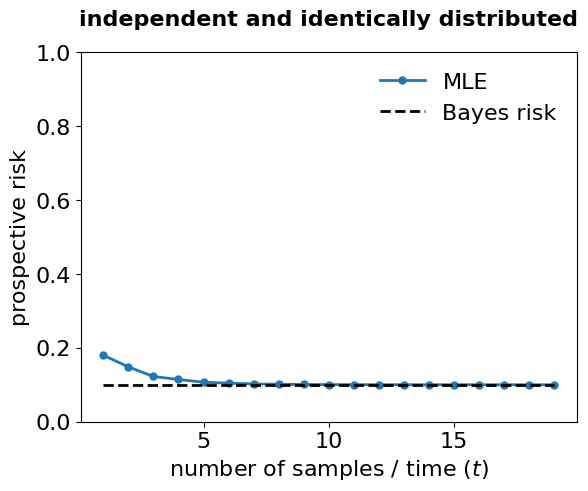

In [447]:
fig, ax = plt.subplots()
color = sns.color_palette("tab10")[3]
ax.plot(t_list, risk, label='MLE', marker='o', ms=5, lw=2)
ax.plot(t_list, (1-p)*np.ones((len(t_list),)), label='Bayes risk', color='k', ls='dashed', lw=2)
ax.legend(frameon=False)
ax.set_ylabel('prospective risk')
ax.set_xlabel(r'number of samples / time ($t$)')
ax.set_title('independent and identically distributed', fontsize=16, fontweight='bold', y=1.05)
ax.set_ylim([0, 1])
plt.show()

In [448]:
case1_outputs = {
    'risk': risk,
    'time': t_list
}

In [203]:
fig.savefig("figures/case1.pdf", bbox_inches='tight')

### Case 2: Independent

Given the observed data $x_1, \dots, x_t$, we consider the following estimates.

L1:

$$\hat p_s = \frac{1}{t} \left( \sum_{\text{odd} \ r}^t x_r + \sum_{\text{even} \ r}^t x_r \right)$$
$$
\hat h_s = 
\begin{cases}
    \text{Threshold}(\hat p_s), & s \ \text{odd} \\
    \text{Threshold}(\hat 1-p_s), & s \ \text{even} \\
\end{cases}
$$

L2: 

$$\hat p_s = \frac{1}{t} \sum_{\text{odd} \ r}^t x_r$$
$$\hat q_s = \frac{1}{t} \sum_{\text{even} \ r}^t x_r$$
$$
\hat h_s = 
\begin{cases}
    \text{Threshold}(\hat p_s), & s \ \text{odd} \\
    \text{Threshold}(\hat q_s), & s \ \text{even} \\
\end{cases}
$$

In [449]:
def loss(truth, pred):
    return (truth - pred)**2

def compare_with_tolerance(num1, num2, atol=1e-9, rtol=1e-9):
    """
    Compare two numbers with numerical tolerance using numpy.isclose().
    Parameters:
        num1 (float): First number
        num2 (float): Second number
        atol (float): Absolute tolerance value for numerical comparison
        rtol (float): Relative tolerance value for numerical comparison
    Returns:
        int: 1 if num1 > num2, -1 if num1 < num2, 0 if num1 and num2 are within tolerance
    """
    if np.isclose(num1, num2, atol=atol, rtol=rtol):
        return 0
    elif num1 > num2 and not np.isclose(num1, num2, atol=atol, rtol=rtol):
        return 1
    elif num1 < num2 and not np.isclose(num1, num2, atol=atol, rtol=rtol):
        return -1
    else:
        return 0
    
def hypothesis(p, size):
    h = np.random.uniform(low=0, high=1, size=size)
    h[p > 0.5] = 1
    h[p < 0.5] = 0
    return h.astype('float')

def compute_mle(data):
    return np.mean(data, axis=-1)

def term_hypothesis(phat, qhat, pattern, t, T):
    h = np.random.uniform(low=0, high=1, size=T-t)
    theta = np.zeros((T-t,))
    mask = pattern[t:T]
    theta[mask] = phat
    theta[~mask] = qhat
    h[theta > 0.5] = 1
    h[theta < 0.5] = 0
    return h.astype('float')

def compute_term_mle(past_data, pattern, type=1):
    if type == 1:
        data = np.copy(past_data)
        t = len(data)
        mask = pattern[:t]
        phat = data[mask].mean() if t==1 else (data[mask].mean() + (1 - data[~mask].mean()))/2
        return phat, 1-phat
    elif type == 2:
        data = np.copy(past_data)
        t = len(data)
        mask = np.copy(pattern[:t])
        phat = data[mask].mean()
        qhat = 0.5 if t==1 else data[~mask].mean()
        return phat, qhat
    else:
        data = np.copy(past_data)
        T = len(pattern)
        t = len(data)

        # ABAB
        pattern1 = pattern
        mask1 = pattern1[:t]

        data1 = np.copy(data)
        phat1 = data[mask1].mean()
        qhat1 = 0.5 if t==1 else data[~mask1].mean()

        L1 = bernoulli.logpmf(data1[mask1], phat1).sum() + bernoulli.logpmf(data1[~mask1], qhat1).sum()

        # AABBAABB
        pattern2 = np.array([True, True, False, False]*T)[:T]
        mask2 = pattern2[:t]

        data2 = np.copy(data)
        phat2 = data[mask2].mean()
        qhat2 = 0.5 if (t==1 or t==2) else data[~mask2].mean()

        L2 = bernoulli.logpmf(data2[mask2], phat2).sum() + bernoulli.logpmf(data2[~mask2], qhat2).sum()

        flag = compare_with_tolerance(L1, L2, atol=1e-9, rtol=1e-9)
        if flag == 1:
            return phat1, qhat1, pattern1
        elif flag == -1:
            return phat2, qhat2, pattern2
        else:
            return phat1, qhat1, pattern1

# attempt to compute the p-value via GLRT
# model 1: ABAB, model 2: always A
# 4.4.3 Baum Welch (just the M step)

In [452]:
p = 0.9
q = round(1-p, 2)
T = 20

In [453]:
# list all possible outcomes of the process
outcomes = np.array(list(map(list, itertools.product([0, 1], repeat=T)))).astype('float')

# ABAB pattern
pattern = np.array([True, False]*T)[:T]

# compute the probability of each outcome using the product measure
probs = np.copy(outcomes)
A = probs[:, pattern]
A[A == 1], A[A == 0] = p, round(1-p, 2)
probs[:, pattern] = A
B = probs[:, ~pattern]
B[B == 1], B[B == 0] = q, round(1-q, 2)
probs[:, ~pattern] = B

prob_weight = np.sum(np.log(probs), axis=-1)

t_list = np.arange(1, T, 1)
risk = []

def loop(i, t, outcomes, pattern):
    past_data = outcomes[i, :t]
    future_data = outcomes[i, t:]
    losses = []
    
    # MLE 1
    p_hat, q_hat = compute_term_mle(past_data, pattern, type=1)
    h = term_hypothesis(p_hat, q_hat, pattern, t, T)
    losses.append(np.mean(loss(future_data, h)))

    # MLE 2
    p_hat, q_hat = compute_term_mle(past_data, pattern, type=2)
    h = term_hypothesis(p_hat, q_hat, pattern, t, T)
    losses.append(np.mean(loss(future_data, h)))

    # MLE 3
    p_hat, q_hat, pred_pattern = compute_term_mle(past_data, pattern, type=3)
    h = term_hypothesis(p_hat, q_hat, pred_pattern, t, T)
    losses.append(np.mean(loss(future_data, h)))

    # naive MLE
    p_hat = compute_mle(past_data)
    h = hypothesis(p_hat, future_data.shape)
    losses.append(np.mean(loss(future_data, h)))
    return losses

for t in t_list:
    tmp = Parallel(n_jobs=-1)(delayed(loop)(i, t, outcomes, pattern) for i in range(len(outcomes)))
    risk.append(np.average(tmp, weights=np.exp(prob_weight), axis=0))
risk = np.array(risk)

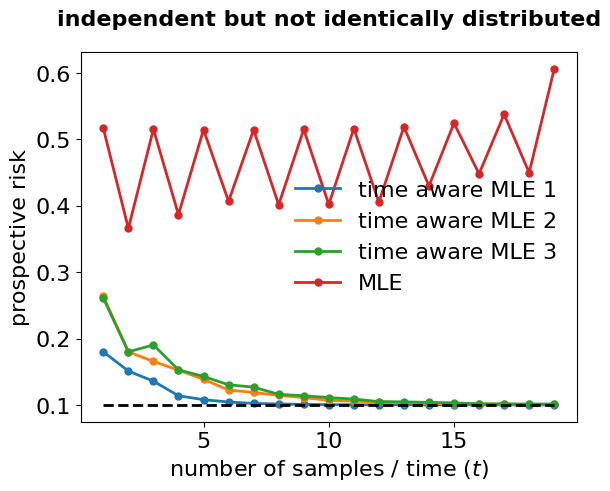

In [454]:
fig, ax = plt.subplots()
labels = [r'time aware MLE 1', r'time aware MLE 2', r'time aware MLE 3', r'MLE']
for i, label in enumerate(labels):
    ax.plot(t_list, risk[:, i], label=label, marker='o', ms=5, lw=2)
ax.plot(t_list, (1-p)*np.ones((len(t_list),)), color='k', ls='dashed', lw=2)
ax.legend(frameon=False)
ax.set_ylabel('prospective risk')
ax.set_xlabel(r'number of samples / time ($t$)')
ax.set_title('independent but not identically distributed', fontsize=16, fontweight='bold', y=1.05)
# ax.set_ylim([0, 1])
plt.show()

In [455]:
case2_outputs = {
    "risk": risk, 
    "time": t_list
}

In [210]:
# fig.savefig("figures/case2.pdf", bbox_inches='tight')

### Final Figure

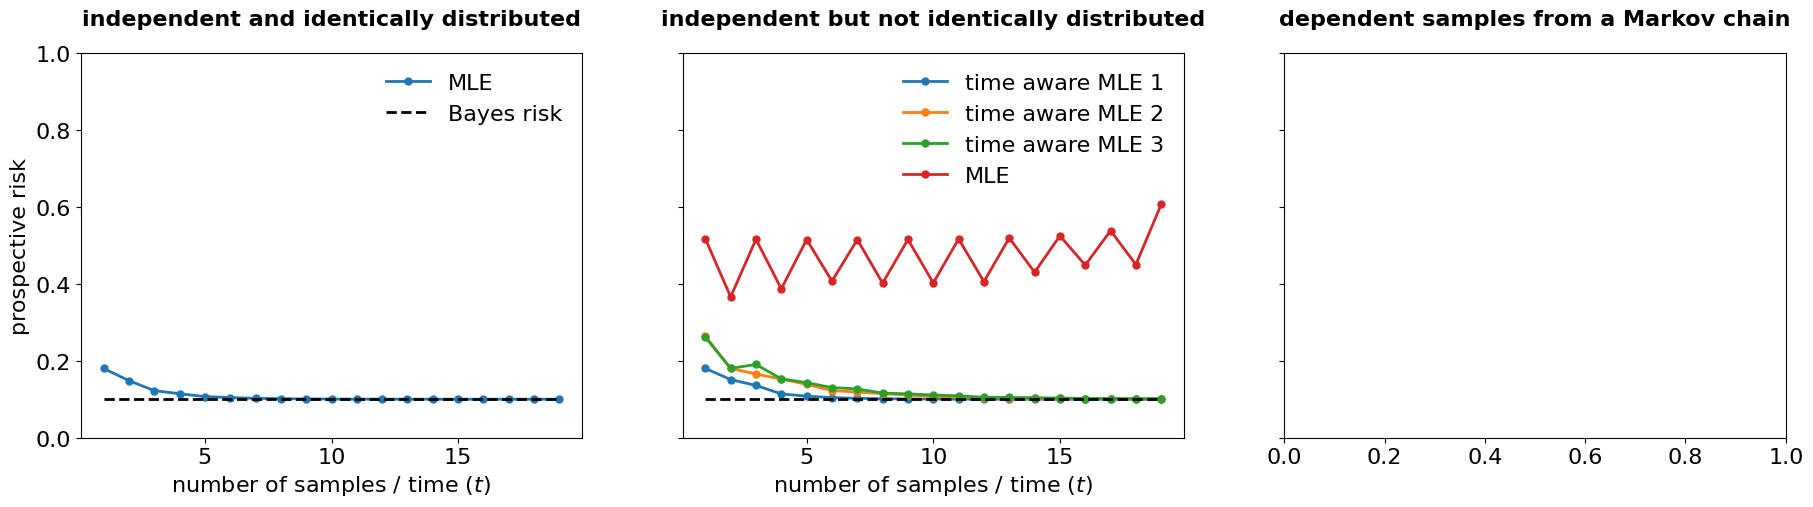

In [456]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5), sharey=True)

ax = axes[0]

risk = case1_outputs['risk']
t_list = case1_outputs['time']
ax.plot(t_list, risk, label='MLE', marker='o', ms=5, lw=2)
ax.plot(t_list, (1-p)*np.ones((len(t_list),)), label='Bayes risk', color='k', ls='dashed', lw=2)
ax.legend(frameon=False)
ax.set_ylabel('prospective risk')
ax.set_xlabel(r'number of samples / time ($t$)')
ax.set_title('independent and identically distributed', fontsize=16, fontweight='bold', y=1.05)
ax.set_ylim([0, 1])

ax = axes[1]

risk = case2_outputs['risk']
t_list = case2_outputs['time']
labels = [r'time aware MLE 1', r'time aware MLE 2', r'time aware MLE 3', r'MLE', ]
for i, label in enumerate(labels):
    ax.plot(t_list, risk[:, i], label=label, marker='o', ms=5, lw=2)
ax.plot(t_list, (1-p)*np.ones((len(t_list),)), color='k', ls='dashed', lw=2)
ax.legend(frameon=False)
ax.set_xlabel(r'number of samples / time ($t$)')
ax.set_title('independent but not identically distributed', fontsize=16, fontweight='bold', y=1.05)
ax.set_ylim([0, 1])

ax = axes[2]
ax.set_title('dependent samples from a Markov chain', fontsize=16, fontweight='bold', y=1.05)

plt.show()

In [457]:
fig.savefig("figures/prol-scenarios.pdf", bbox_inches='tight')

### Dev

In [3]:
# run a replicate
def run_replicate(t, T, p, prior_mode, prior_conc, reps):
    # sample a t-length sequence
    past_data = sample_from_process(p, (t,))  

    L = Learners(past_data, t, T, prior_mode, prior_conc)  

    # sample replicate sequences of the future data
    size = (reps, T-t)
    future_data = sample_from_process(p, size)

    # evaluate the hypothesis on each of the replicate sequences and compute average loss per replicate
    average_losses_mle = np.mean(loss(future_data, L.hypothesis(size, type=1)), axis=-1)
    average_losses_map = np.mean(loss(future_data, L.hypothesis(size, type=2)), axis=-1)
    # average_losses_pro = np.mean(loss(future_data, L.hypothesis(size, type=3)), axis=-1)
    
    # compute the the average risk conditioned on the past data
    return np.mean(average_losses_mle), np.mean(average_losses_map)

In [8]:
# params
p = 0.9
T = 20
t_list = np.arange(1, T, 1)

In [9]:
expected_risks = []
std = []
for t in t_list:
    tmp = Parallel(n_jobs=-1)(delayed(run_replicate)(t, T, p, prior_mode, prior_conc, reps) for _ in range(reps))
    # compute the expected risk
    expected_risks.append(np.mean(tmp, axis=0))
    std.append(np.std(tmp, axis=0))

expected_risks = np.array(expected_risks)
std = np.array(std)
bayes_risk = (1-p)*np.ones((len(t_list),))

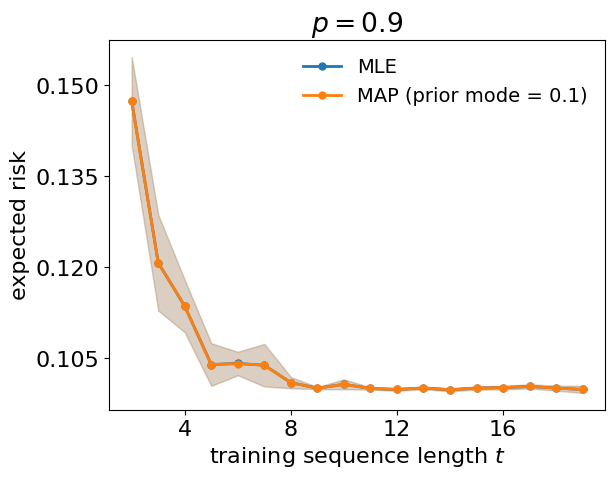

In [10]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab10")

labels = ['MLE', f'MAP (prior mode = {prior_mode})']
for i, label in enumerate(labels):
    ax.plot(t_list, expected_risks[:, i], 
            label=label, 
            color=colors[i], marker='o', ms=5, lw=2)
    ci = np.array(std[:, i]) * 1.96 / np.sqrt(reps)
    ax.fill_between(t_list, expected_risks[:, i]-ci, expected_risks[:, i]+ci, color=colors[i], alpha=0.2)

# ax.plot(t_list, bayes_risk, lw=3, marker='o', ls='dashed', ms=5, color='k', label='bayes risk')

ax.set_xlabel(r'training sequence length $t$')
ax.set_ylabel('expected risk')
ax.set_title(fr"$p = {p}$")
ax.legend(frameon=False, fontsize=14)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.show()

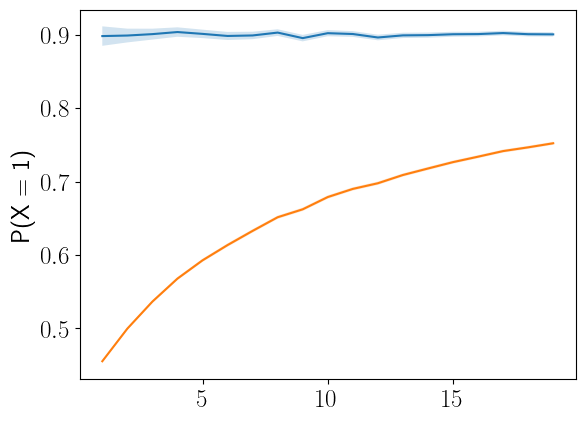

In [346]:
fig, ax = plt.subplots()
idxs = [-1, -2]
for i in idxs:
    ax.plot(t_list, expected_risks[:, i])
    ci = np.array(std[:, i]) * 1.96 / np.sqrt(reps)
    ax.fill_between(t_list, expected_risks[:, i]-ci, expected_risks[:, i]+ci, alpha=0.2)
    ax.set_ylabel('P(X = 1)')

In [289]:
# # save
# fig.savefig("figures/case1.pdf", bbox_inches='tight')

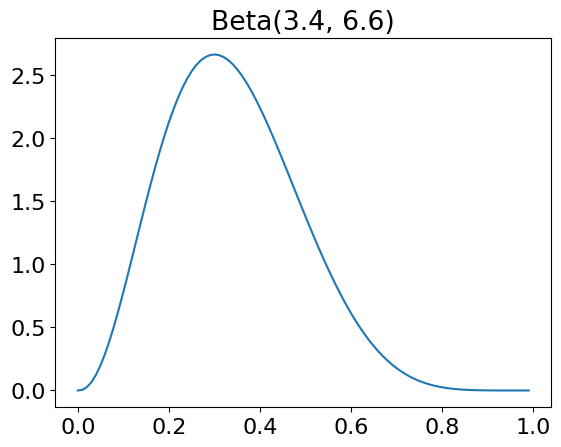

In [34]:
L = Learners(mode=prior_mode, conc=prior_conc)  
plt.plot(np.arange(0, 1, 0.01), beta(L.alpha, L.beta).pdf(np.arange(0, 1, 0.01)))
plt.title(f'Beta({L.alpha}, {L.beta})')
plt.show()

In [14]:
def loop(p, t, prior_mode, prior_conc):
    past_data = sample_from_process(p, (t,))
    L = Learners(past_data, t, T, prior_mode, prior_conc)
    alpha, beta = L.alpha, L.beta
    alpha_pos = alpha + np.sum(past_data)
    beta_pos = beta + t - np.sum(past_data)
    thresh = (alpha + t/2)/(alpha + beta + t - 2)
    return 1 - beta_dist.cdf(thresh, alpha_pos, beta_pos)

In [25]:
reps = 1000
prior_conc = 15
t_list = np.arange(1, 20, 1)

def compute_prob(t_list, p, prior_mode, prior_conc):
    prob = []
    for t in t_list:
        tmp = Parallel(n_jobs=-1)(delayed(loop)(p, t, prior_mode, prior_conc) for _ in range(1000))
        prob.append(np.mean(tmp))
    return prob

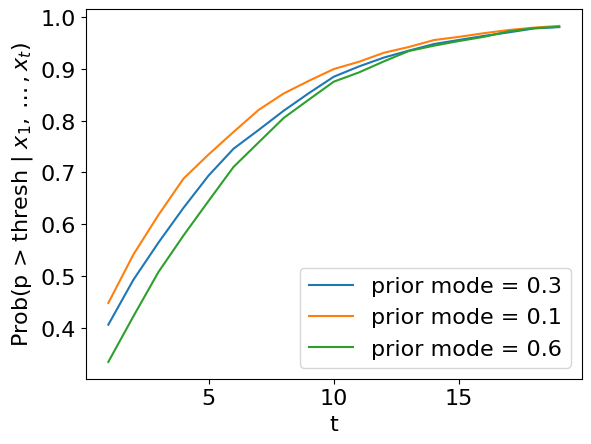

In [28]:
plt.plot(t_list, compute_prob(t_list, p, 0.3, 15), label='prior mode = 0.3')
plt.plot(t_list, compute_prob(t_list, p, 0.1, 15), label='prior mode = 0.1')
plt.plot(t_list, compute_prob(t_list, p, 0.6, 15), label='prior mode = 0.6')
plt.xlabel('t')
plt.ylabel(r'Prob(p > thresh | $x_1, \dots, x_t$)')
plt.legend()

### Case 2: Independent

Given the observed data $x_1, \dots, x_t$, we consider the following estimates.

L1:

$$\hat p_s = \frac{1}{t} \left( \sum_{\text{odd} \ r}^t x_r + \sum_{\text{even} \ r}^t x_r \right)$$
$$
\hat h_s = 
\begin{cases}
    \text{Threshold}(\hat p_s), & s \ \text{odd} \\
    \text{Threshold}(\hat 1-p_s), & s \ \text{even} \\
\end{cases}
$$

L2: 

$$\hat p_s = \frac{1}{t} \sum_{\text{odd} \ r}^t x_r$$
$$\hat q_s = \frac{1}{t} \sum_{\text{even} \ r}^t x_r$$
$$
\hat h_s = 
\begin{cases}
    \text{Threshold}(\hat p_s), & s \ \text{odd} \\
    \text{Threshold}(\hat q_s), & s \ \text{even} \\
\end{cases}
$$

Bigram Model:

Based on the observations $x_1, \dots, x_t$, we estimate the $2 \times 2$ state transition matrix $P$ where $P_{ij} = prob(x_t = i \mid x_{t-1} = j)$. During inference, we first compute the state probability distirbution at $s > t$ by
$$ p_s = p_t P^{s-t} $$ 
where $p_t = [0, 1]$ is $x_t = 1$ and $p_t = [1, 0]$ otherwise. The predicted outcome at $s$ is given by,
$$ h_s = \text{threshold}(p_s) $$


In [42]:
class Learners:
    def __init__(self, data=None, t=None, T=None) -> None:
        self.t = t
        self.T = T
        self.data = data
        
        # case 1:
        self.phat1 = self.compute_phat()

        # case 2:
        self.phat2, self.qhat2 = self.compute_pqhat()

        # case 3: 
        self.T = self.compute_transition_matrix()

    def compute_phat(self):
        data = np.copy(self.data)
        tmp = data[1::2]
        data[1::2] = 1-tmp
        return np.mean(data)
    
    def compute_pqhat(self):
        data = np.copy(self.data)
        tmp1 = data[0::2]
        tmp2 = data[1::2]
        p_hat = np.mean(tmp1)
        q_hat = 0.5 if len(tmp2)==0 else np.mean(tmp2)
        return p_hat, q_hat
    
    def compute_alpha_beta(self, mode, conc):
        alpha = mode * (conc - 2) + 1
        beta = (1 - mode) * (conc - 2) + 1
        return alpha, beta
    
    def compute_map(self, count, total,alpha, beta):
        nom = alpha + count - 1
        denom = alpha + beta + total - 2
        return nom/denom
    
    def compute_transition_matrix(self, bayesian=True):
        data = np.copy(self.data)
        T = {0: {0: 0, 1: 0}, 
             1: {0: 0, 1: 0}}
        for i in range(len(data)-1):
            u, v = data[i], data[i+1]
            T[u][v] += 1
        if bayesian:
            prior = lambda mode : self.compute_alpha_beta(mode, 8)
            for u, i in enumerate(T):
                if i == 0:
                    params = [prior(0.4), prior(0.6)]
                else:
                    params = [prior(0.6), prior(0.4)]
                total = sum(T[u].values())
                T[u] = dict([(v, self.compute_map(T[u][v], total, param[0], param[1])) for v, param in zip(T[u], params)])
        else:
            for u in T:
                T[u] = dict([(v, T[u][v]+1) for v in T[u]])
                total = sum(T[u].values())
                T[u] = dict([(v, T[u][v]/total) for v in T[u]])
        return T

    def hypothesis1(self, start, size):
        h = np.random.uniform(low=0, high=1, size=size)
        out = int(self.phat1 > 0.5)
        if start % 2:
            if self.phat1 != 0.5: h[:, 0::2], h[:, 1::2] = out, 1-out
        else:
            if self.phat1 != 0.5: h[:, 0::2], h[:, 1::2] = 1-out, out
        return h
    
    def hypothesis2(self, start, size):
        h = np.random.uniform(low=0, high=1, size=size)
        out_p = int(self.phat2 > 0.5)
        out_q = int(self.qhat2 > 0.5)
        if start % 2:
            if self.phat2 != 0.5: h[:, 0::2] = out_p 
            if self.qhat2 != 0.5: h[:, 1::2] = out_q
        else:
            if self.qhat2 != 0.5: h[:, 0::2] = out_q
            if self.phat2 != 0.5: h[:, 1::2] = out_p
        return h
    
    def hypothesis3(self, start, size):
        T = np.array([list(self.T[i].values()) for i in self.T])
        p_t = np.zeros((2, ))
        p_t[self.data[-1]] = 1
        h = np.random.uniform(low=0, high=1, size=size)
        p_s = p_t @ T
        for s in range(size[-1]):
            if p_s[1] != 0.5: h[:, s] = int(p_s[1] > 0.5)
            p_s = p_s @ T
        return h

    def hypothesis4(self, start, size):
        def next_outcome(prev_outcome):
            return max(self.T[prev_outcome], key=self.T[prev_outcome].get)
        h = np.ones(size)
        outcomes = []
        prev = self.data[-1]
        for _ in range(size[-1]):
            tmp = next_outcome(prev)
            outcomes.append(tmp)
            prev = tmp
        return h * outcomes   

def sample_from_process(p, q, start, size=None):
    order = [p, q] if start % 2 else [q, p]
    t = size[-1]
    p_list = order * (t // 2)
    if t % 2:
        p_list.append(order[0])
    return np.random.binomial(n=1, p=np.ones(size) * p_list)

def loss(truth, pred):
    return (truth - pred)**2

In [43]:
# run a replicate
def run_replicate(t, T, p, q, reps):
    # sample a t-length sequence
    past_data = sample_from_process(p, q, start=1, size=(t,))

    L = Learners(past_data, t, T)

    # sample replicate sequences of the future data
    size = (reps, T-t)
    future_data = sample_from_process(p, q, start=t+1, size=size)

    # evaluate the hypothesis on each of the replicate sequences and compute average loss per replicate
    average_losses_1 = np.mean(loss(future_data, L.hypothesis1(t+1, size)), axis=-1)
    average_losses_2 = np.mean(loss(future_data, L.hypothesis2(t+1, size)), axis=-1)
    average_losses_3 = np.mean(loss(future_data, L.hypothesis3(t+1, size)), axis=-1)
    # average_losses_4 = np.mean(loss(future_data, L.hypothesis4(t+1, size)), axis=-1)
    
    # compute the the average risk conditioned on the past data
    return np.mean(average_losses_1), np.mean(average_losses_2), np.mean(average_losses_3), # np.mean(average_losses_4)

In [44]:
# params
p = 0.9
q = 1-p
T = 20
t_list = np.arange(1, T, 1)
reps = 1000

In [45]:
expected_risks = []
std = []
for t in t_list:
    tmp = Parallel(n_jobs=-1)(delayed(run_replicate)(t, T, p, q, reps) for _ in range(reps))
    # compute the expected risk
    expected_risks.append(np.mean(tmp, axis=0))
    std.append(np.std(tmp, axis=0))

expected_risks = np.array(expected_risks)
std = np.array(std)
bayes_risk = (1-p)*np.ones((len(t_list),))

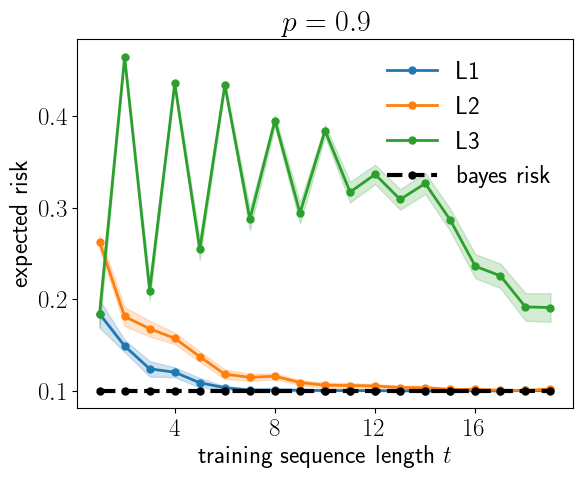

In [46]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab10")

labels = ['L1', 'L2', 'L3']
for i, label in enumerate(labels):
    ax.plot(t_list, expected_risks[:, i], 
            label=f'{label}', 
            color=colors[i], marker='o', ms=5, lw=2)
    ci = np.array(std[:, i]) * 1.96 / np.sqrt(reps)
    ax.fill_between(t_list, expected_risks[:, i]-ci, expected_risks[:, i]+ci, color=colors[i], alpha=0.2)

ax.plot(t_list, bayes_risk, lw=3, marker='o', ls='dashed', ms=5, color='k', label='bayes risk')

ax.set_xlabel(r'training sequence length $t$')
ax.set_ylabel('expected risk')
ax.set_title(fr"$p = {p}$")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.show()

In [47]:
# save
fig.savefig("figures/case2.pdf", bbox_inches='tight')

In [366]:
def test_run(t, T, p, q, reps):
    past_data = sample_from_process(p, q, start=1, size=(t,))
    L = Learners(past_data, t, T)  
    T = np.array([list(L.T[i].values()) for i in L.T])
    return T.ravel()

In [367]:
probs = []
for t in t_list:
    tmp = Parallel(n_jobs=-1)(delayed(test_run)(t, T, p, q, reps) for _ in range(reps))
    probs.append(np.mean(tmp, axis=0))

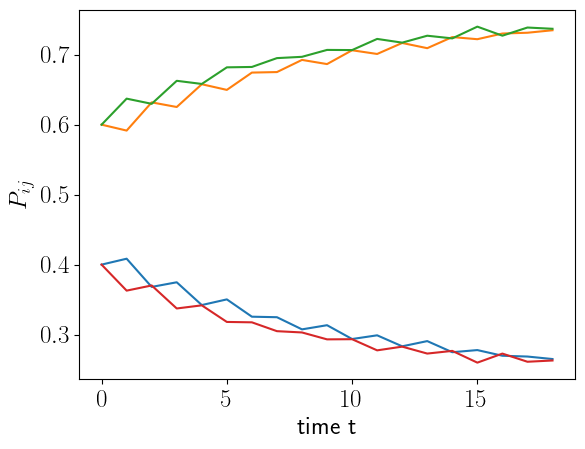

In [368]:
plt.plot(probs)
plt.xlabel('time t')
plt.ylabel(r'$P_{ij}$')
plt.show()

In [201]:
def hypothesis3(T, start, size):
    p_t = np.zeros((2, ))
    p_t[start] = 1
    h = np.random.uniform(low=0, high=1, size=size)
    p_s = p_t @ T
    for s in range(size[-1]):
        if p_s[1] != 0.5: h[:, s] = int(p_s[1] > 0.5)
        p_s = p_s @ T
    return h          

In [211]:
T = np.array([[0.2, 0.8], 
             [0.8, 0.2]])
hypothesis3(T, start = 1, size=(1, 100))

array([[0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.23740406,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.  

#### Sub-case 4: Bigram modeling

In [351]:
def train(data):
    # create bigram model
    bigrams = {0: {0: 0, 1: 0}, 
               1: {0: 0, 1: 0}}
    for i in range(len(data)-1):
        u, v = data[i], data[i+1]
        bigrams[u][v] += 1
    for u in bigrams:
        bigrams[u] = dict([(v, bigrams[u][v]+1) for v in bigrams[u]])
        total = sum(bigrams[u].values())
        bigrams[u] = dict([(v, bigrams[u][v]/total) for v in bigrams[u]])
    return bigrams

def predict(bigrams, data, size): 
    def next_outcome(outcome):
        if list(bigrams[outcome].values()) == [0.5, 0.5]:
            return np.random.binomial(n=1, p=0.5)
        else:
            return max(bigrams[outcome], key=bigrams[outcome].get)
    preds = []
    for _ in range(size[0]):
        prev_outcome = data[-1]
        tmp = []
        for _ in range(size[-1]):
            outcome = next_outcome(prev_outcome)
            tmp.append(outcome)
            prev_outcome = outcome
        preds.append(tmp)
    return np.array(preds)

In [352]:
p = 0.9
q = 1-p
T = 20
t_list = np.arange(1, T, 1)
reps = 500
expected_future_risks_4 = []
std_4 = []
probs = []
for t in t_list:
    tmp = []
    tmp1 = []
    # randomly sample a training set
    for _ in range(reps):
        # sample a t-length sequence
        past_data = sample_from_process(p, q, start=1, size=(t,))
        bigrams = train(past_data)
        tmp1.append([bigrams[0][0], bigrams[0][1], bigrams[1][0], bigrams[1][1]])

        # sample future data
        future_data = sample_from_process(p, q, start=t+1, size=(reps, T-t))

        # evaluate the hypothesis on each of the 500 replicate sequences
        preds = predict(bigrams, past_data, size=(reps, T-t))
        cumulative_losses = np.mean((future_data - preds)**2, axis=-1)

        # compute the integrated risk divided by future duration
        future_risk = np.mean(cumulative_losses)
        tmp.append(future_risk)
    
    # compute the expected integrated risk by averaging out the randomness of training data 
    expected_future_risks_4.append(np.mean(tmp))
    std_4.append(np.std(tmp))

    probs.append(np.mean(tmp1, axis=0))

bayes_risk = (1-p)*np.ones((len(t_list),))

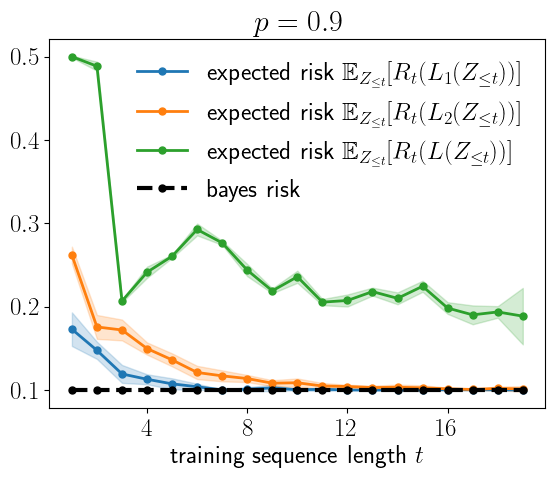

In [353]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab10")

color = colors[0]
ax.plot(t_list, expected_future_risks_1, 
         label=r'expected risk $\mathbb{E}_{Z_{\leq t}}[R_t(L_1(Z_{\leq t}))]$', 
         color=color, marker='o', ms=5, lw=2)
ci = np.array(std_1) * 1.96 / np.sqrt(reps)
ax.fill_between(t_list, expected_future_risks_1-ci, expected_future_risks_1+ci, color=color, alpha=0.2)

color = colors[1]
ax.plot(t_list, expected_future_risks_2, 
         label=r'expected risk $\mathbb{E}_{Z_{\leq t}}[R_t(L_2(Z_{\leq t}))]$', 
         color=color, marker='o', ms=5, lw=2)
ci = np.array(std_2) * 1.96 / np.sqrt(reps)
ax.fill_between(t_list, expected_future_risks_2-ci, expected_future_risks_2+ci, color=color, alpha=0.2)

color = colors[2]
ax.plot(t_list, expected_future_risks_4, 
         label=r'expected risk $\mathbb{E}_{Z_{\leq t}}[R_t(L(Z_{\leq t}))]$', 
         color=color, marker='o', ms=5, lw=2)
ci = np.array(std_3) * 1.96 / np.sqrt(reps)
ax.fill_between(t_list, expected_future_risks_4-ci, expected_future_risks_4+ci, color=color, alpha=0.2)

ax.plot(t_list, bayes_risk, lw=3, marker='o', ls='dashed', ms=5, color='k', label='bayes risk')

ax.set_xlabel(r'training sequence length $t$')
ax.set_title(fr"$p = {p}$")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.show()

In [ ]:
# save
fig.savefig("figures/case2.pdf", bbox_inches='tight')

In [ ]:
p = 0.9
q = 1-p
T = 20
t_list = np.arange(1, T, 1)
reps = 500
expected_future_risks_4 = []
std_4 = []
probs = []
for t in t_list:
    tmp = []
    tmp1 = []
    # randomly sample a training set
    for _ in range(reps):
        # sample a t-length sequence
        past_data = sample_from_process(p, q, start=1, size=(t,))
        bigrams = train(past_data)
        tmp1.append([bigrams[0][0], bigrams[0][1], bigrams[1][0], bigrams[1][1]])

        # sample future data
        future_data = sample_from_process(p, q, start=t+1, size=(reps, T-t))

        # evaluate the hypothesis on each of the 500 replicate sequences
        preds = predict(bigrams, past_data, size=(reps, T-t))
        cumulative_losses = np.mean((future_data - preds)**2, axis=-1)

        # compute the integrated risk divided by future duration
        future_risk = np.mean(cumulative_losses)
        tmp.append(future_risk)
    
    # compute the expected integrated risk by averaging out the randomness of training data 
    expected_future_risks_4.append(np.mean(tmp))
    std_4.append(np.std(tmp))

    probs.append(np.mean(tmp1, axis=0))

bayes_risk = (1-p)*np.ones((len(t_list),))

In [450]:
class ListNode(object):
    def __init__(self, val=0, next=None):
        self.val = val
        self.next = next

### Case 3: Dependent

In [60]:
def hypothesis():
    return 1

p = 0.8
T = 10

# list all possible outcomes of the process
outcomes = np.array(list(map(list, itertools.product([0, 1], repeat=T)))).astype('float')

# compute the probability of each outcome using the product measure (due to iid assumption)
probs = np.copy(outcomes)
probs[probs == 1] = p
probs[probs == 0] = 1-p
prob_weight = np.prod(probs, axis=-1)

t_list = np.arange(1, T+1, 1)
future_risk_beyond_t = []
cumulative_losses = []

# loop over increasing values of t
for t in range(1, len(t_list), 1):
    # get the cumulative loss for each outcome
    cumulative_loss = np.sum((outcomes[:, t:].astype('int') != hypothesis()), axis=-1)
    cumulative_losses.append(cumulative_loss)
    
    # take the weighted average of the cumulative loss over all the outcomes (weight is the probabilities we computed above)
    expected_cumulative_loss = np.average(cumulative_loss, weights=prob_weight)
    future_risk_beyond_t.append(expected_cumulative_loss)

cumulative_losses = np.array(cumulative_losses)

Text(0.5, 1.0, 'p = 0.8')

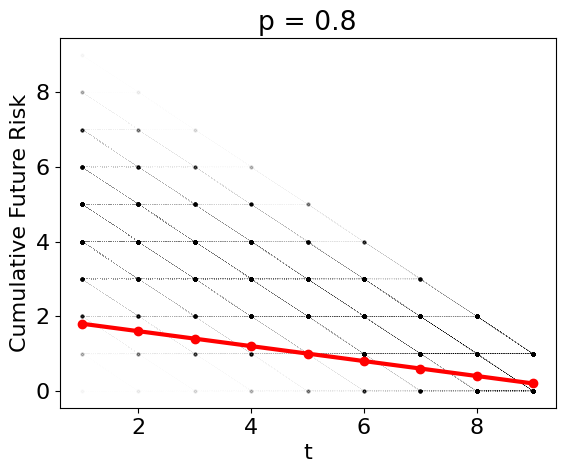

In [62]:
plt.plot(np.arange(1, T, 1), cumulative_losses, ls='dotted', marker='o', alpha=0.01, color='k', lw=0.5, ms=2)
plt.plot(np.arange(1, T, 1), future_risk_beyond_t, color='r', lw=3, marker='o')
plt.xlabel('t')
plt.ylabel(r'Cumulative Future Risk') # + '\n' + r'$R_t(h_{\geq t})$')
plt.title(f"p = {p}")

In [80]:
def hypothesis(p_hat):
    return (p_hat > 0.5).astype('int')

p = 0.8
T = 20 # length of the process being considered

# list all possible outcomes of the process
outcomes = np.array(list(map(list, itertools.product([0, 1], repeat=T)))).astype('float')

# compute the probability of each outcome using the product measure (due to iid assumption)
probs = np.copy(outcomes)
probs[probs == 1] = p
probs[probs == 0] = 1-p
prob_weight = np.prod(probs, axis=-1)

t_list = np.arange(1, T+1, 1)
future_risk_beyond_t = []

# loop over increasing values of t
for t in range(1, len(t_list), 1):

    # get the past (training) data at each outcome
    past_outcomes = outcomes[:, :t]

    # get the future (evaluation) data at each outcome
    future_outcomes = outcomes[:, t:]

    # compute the p_hat at each outcome based on past data
    p_hat = np.mean(past_outcomes, axis=-1)

    # get the hypothesis for each outcome
    h = np.repeat(hypothesis(p_hat).reshape(-1, 1), len(t_list)-t, axis=-1)

    # get the cumulative loss for each outcome
    cumulative_loss = np.mean((future_outcomes.astype('int') != h), axis=-1)

    # take the weighted average of the cumulative loss over all the outcomes (weight is the probabilities we computed above)
    expected_cumulative_loss = np.average(cumulative_loss, weights=prob_weight)
    future_risk_beyond_t.append(expected_cumulative_loss)

Text(0.5, 1.0, 'p = 0.8')

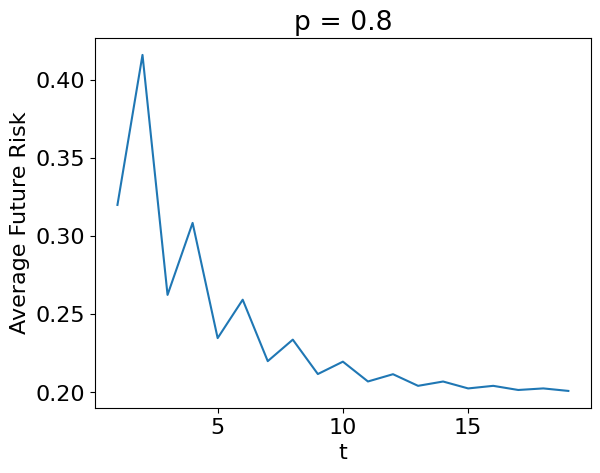

In [81]:
plt.plot(np.arange(1, T, 1), future_risk_beyond_t)
plt.xlabel('t')
plt.ylabel(r'Average Future Risk')
plt.title(f"p = {p}")

In [27]:
def get_p_hat(seq, alpha=2, beta=2):
    return np.divide(alpha + np.sum(seq) - 1, alpha + beta + len(seq) - 2)

def hypothesis(p_hat, size):
    if p_hat > 0.5:
        return 1
    elif p_hat < 0.5:
        return 0
    else:
        return np.random.uniform(low=0, high=1, size=size)
    
p = 0.8
T = 10
t_list = np.arange(1, T+1, 1)

conditional_risks_for_several_outcomes = []
outcomes = []
for _ in range(5):
    # sample an outcome (sequence) from the process
    outcome_from_the_process = np.random.binomial(n=1, p=p*np.ones(T))
    outcomes.append(outcome_from_the_process)

    conditional_average_future_risk = []
    for t in t_list:
        if t == T:
            break
        # compute p_hat based on the first t samples of the sequence
        p_hat = get_p_hat(outcome_from_the_process[:t])

        # sample replicates of the future sequence of length T-t (future distribution doesn't depend on the past, so no effect from the past data here)
        size = (1000, T-t)
        future_data = np.random.binomial(n=1, p=p*np.ones(size))

        # compute the average future loss on each of the replicate future sequences
        average_future_loss = np.sum((future_data - hypothesis(p_hat, size))**2, axis=-1)

        # compute the average future risk
        average_future_risk = np.mean(average_future_loss)

        conditional_average_future_risk.append(average_future_risk)
    conditional_risks_for_several_outcomes.append(conditional_average_future_risk)
    
conditional_risks_for_several_outcomes = np.array(conditional_risks_for_several_outcomes).T

bayes_cumulative_error = []
for t in t_list:
    if t == T:
        break
    bayes_cumulative_error.append(np.sum(0.2 * np.ones((T-t,))))

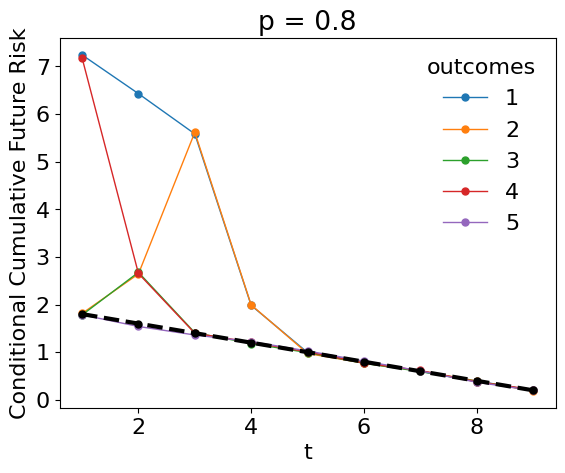

In [33]:
plt.plot(t_list[:-1], conditional_risks_for_several_outcomes, lw=1, marker='o', ms=5)
plt.plot(t_list[:-1], bayes_cumulative_error, lw=3, marker='o', ls='dashed', ms=5, color='k', label='Bayes Error')
plt.xlabel('t')
plt.ylabel(r'Conditional Cumulative Future Risk')
plt.title(f"p = {p}")
plt.legend(np.arange(1, 6, 1), title='outcomes', frameon=False)